This notebook is based on the file [Embeddings programming exercise](https://colab.research.google.com/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=embeddings-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Sparse Data and Embeddings

**Learning Objectives:**
* Convert movie-review string data to a feature vector
* Implement a sentiment-analysis linear model using a feature vector
* Implement a sentiment-analysis DNN model using an embedding that projects data into two dimensions
* Visualize the embedding to see what the model has learned about the relationships between words

In this exercise, we'll explore sparse data and work with embeddings using text data from movie reviews (from the [ACL 2011 IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/)). Open and run [TFrecord Extraction.ipynb](https://colab.research.google.com/drive/1QFN8BCJJKVraUOk-lmR9fF3bRXRlz9FI#forceEdit=true&sandboxMode=true) Colaboratory notebook to extract the data from the original `.tfrecord` file as Julia variables.

## Setup

Let's import our dependencies and open the training and test data. We have exported the test and training data as `hdf5` files in the previous step, so we use the `HDF5`-package to load the data.

In [1]:
using Plots
using Distributions
gr()
using DataFrames
using TensorFlow
import CSV
import StatsBase
using PyCall
@pyimport sklearn.metrics as sklm
using Images
using Colors
using HDF5

sess=Session(Graph())

Session(Ptr{Void} @0x0000000128c2ac30)

Open the test and training raw data sets.

In [2]:
c = h5open("train_data.h5", "r") do file
   global train_labels=read(file, "output_labels")
   global train_features=read(file, "output_features")
end
c = h5open("test_data.h5", "r") do file
   global test_labels=read(file, "output_labels")
   global test_features=read(file, "output_features")
end
train_labels=train_labels'
test_labels=test_labels';

2018-09-16 16:21:02.045635: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


Have a look at one data set:

In [4]:
test_labels[301,:]

1-element Array{Float32,1}:
 1.0

In [5]:
test_features[301]

"['\"' 'don' \"'\" 't' 'change' 'your' 'husband' '\"' 'is' 'another' 'soap'\n 'opera' 'comedy' 'from' 'producer' '/' 'director' 'cecil' 'b' '.' 'de'\n 'mille' '.' 'it' 'is' 'notable' 'as' 'the' 'first' 'of' 'several' 'films'\n 'he' 'made' 'starring' 'gloria' 'swanson' '.' 'i' 'guess' 'you' 'could'\n 'also' 'call' 'it' 'a' 'sequel' 'of' 'sorts' 'to' 'his' '\"' 'old' 'wives'\n 'for' 'new' '\"' '(' '####' ')' '.' 'james' '(' 'elliot' 'dexter' ')'\n 'and' 'leila' '(' 'swanson' ')' 'porter' 'are' 'a' 'fortyish' 'couple'\n 'where' 'james' 'has' 'gone' 'to' 'seed' 'and' 'become' 'slovenly' 'and'\n 'lazy' '.' 'he' 'has' 'a' 'penchant' 'for' 'smelly' 'cigars' 'and'\n 'eating' 'raw' 'onions' '.' 'he' 'takes' 'his' 'wife' 'for' 'granted' '.'\n 'leila' 'tries' 'to' 'get' 'him' 'to' 'straighten' 'out' 'to' 'no'\n 'avail' '.' 'one' 'night' 'at' 'a' 'dinner' 'party' 'at' 'the' 'porters'\n ',' 'leila' 'meets' 'the' 'dashing' 'schyler' 'van' 'sutphen' '(' 'now'\n \"there's\" 'a' 'moniker' ')' ',' 'the'

## Building a Sentiment Analysis Model

Let's train a sentiment-analysis model on this data that predicts if a review is generally *favorable* (label of 1) or *unfavorable* (label of 0).

To do so, we'll turn our string-value `terms` into feature vectors by using a *vocabulary*, a list of each term we expect to see in our data. For the purposes of this exercise, we've created a small vocabulary that focuses on a limited set of terms. Most of these terms were found to be strongly indicative of *favorable* or *unfavorable*, but some were just added because they're interesting.

Each term in the vocabulary is mapped to a coordinate in our feature vector. To convert the string-value `terms` for an example into this vector format, we encode such that each coordinate gets a value of 0 if the vocabulary term does not appear in the example string, and a value of 1 if it does. Terms in an example that don't appear in the vocabulary are thrown away.

**NOTE:** *We could of course use a larger vocabulary, and there are special tools for creating these. In addition, instead of just dropping terms that are not in the vocabulary, we can introduce a small number of OOV (out-of-vocabulary) buckets to which you can hash the terms not in the vocabulary. We can also use a __feature hashing__ approach that hashes each term, instead of creating an explicit vocabulary. This works well in practice, but loses interpretability, which is useful for this exercise.*

## Building the Input Pipeline

First, let's configure the input pipeline to import our data into a TensorFlow model. We can use the following function to parse the training and test data and return an array of the features and the corresponding labels.

In [3]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
  """Create batches.

  Args:
    features: Input features.
    targets: Target column.
    steps: Number of steps.
    batch_size: Batch size.
    num_epochs: Number of epochs, 0 will let TF automatically calculate the correct number
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """      
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end
    
    features_batches=copy(features)
    target_batches=copy(targets)
    
    for i=1:num_epochs        
        select=shuffle(1:size(features,1))
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else
            features_batches=vcat(features_batches, features[select,:])
            target_batches=vcat(target_batches, targets[select,:])
        end
    end
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [4]:
function construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  out=convert(Array, input_features[:,:])
  return convert.(Float64,out)
end    

construct_feature_columns (generic function with 1 method)

In [5]:
function next_batch(features_batches, targets_batches, batch_size, iter)
  """Next batch.

  Args:
    features_batches: Features batches from create_batches.
    targets_batches: Target batches from create_batches.
    batch_size: Batch size.
    iter: Number of the current iteration
  Returns:
    A batch of features and targets.
  """ 
    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];
    
    return ds, target
end

next_batch (generic function with 1 method)

In [6]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1):
    """Prepares a batch of features and labels for model training.
  
    Args:
      features_batches: Features batches from create_batches.
      targets_batches: Target batches from create_batches.
      iter: Number of the current iteration
      batch_size: Batch size.
      shuffle_flag: Determines wether data is shuffled before being returned
    Returns:
      Tuple of (features, labels) for next data batch
    """  

    # Construct a dataset, and configure batching/repeating.
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    return ds, target
end

my_input_fn (generic function with 3 methods)

## Task 1: Use a Linear Model with Sparse Inputs and an Explicit Vocabulary

For our first model, we'll build a Linear Classifier model using 50 informative terms; always start simple!

The following code constructs the feature column for our terms. 

In [7]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ["bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family"]

50-element Array{String,1}:
 "bad"       
 "great"     
 "best"      
 "worst"     
 "fun"       
 "beautiful" 
 "excellent" 
 "poor"      
 "boring"    
 "awful"     
 "terrible"  
 "definitely"
 "perfect"   
 ⋮           
 "her"       
 "good"      
 "time"      
 "?"         
 "."         
 "!"         
 "movie"     
 "film"      
 "action"    
 "comedy"    
 "drama"     
 "family"    

The following function takes the input data and vocabulary and converts the data to a one-hot encoded matrix.

In [8]:
# function for creating categorial colum from vocabulary list in one hot encoding
function create_data_columns(data, informative_terms)
   onehotmat=zeros(length(data), length(informative_terms))
   
    for i=1:length(data)
        string=data[i]
        for j=1:length(informative_terms)
            if contains(string, informative_terms[j])
                onehotmat[i,j]=1
            end
        end
    end
    return onehotmat
end

create_data_columns (generic function with 1 method)

In [9]:
train_feature_mat=create_data_columns(train_features, informative_terms)
test_features_mat=create_data_columns(test_features, informative_terms);

Next, we'll construct the Linear Classifier model, train it on the training set, and evaluate it on the evaluation set. After you read through the code, run it and see how you do.

In [10]:
function train_linear_classifier_model(learning_rate,
                     steps, 
                     batch_size, 
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a linear classifier model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples, etc: The input data.
  Returns:
    weight: The weights of the linear model.
    bias: The bias of the linear model.
    validation_probabilities: Probabilities for the validation examples.
    p1: Plot of loss function for the different periods
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  eps=1E-8
  
  # these two variables need to be initialized as 0, otherwise method gives problems 
  m=Variable(zeros(size(training_examples,2),1).+0.0)
  b=Variable(0.0)

  ytemp=nn.sigmoid(feature_columns*m + b)
  y= clip_by_value(ytemp, 0.0, 1.0)
  loss = -reduce_mean(log(y+eps).*target_columns + log(1-y-eps).*(1-target_columns)) 

  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
    
  # Advanced Adam optimizer decent with gradient clipping
  my_optimizer=(train.AdamOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.0), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
    
  run(sess, global_variables_initializer()) #this needs to be run after constructing the optimizer!
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses=[]
  for period in 1:periods
    # Train the model, starting from the prior state.
    for i=1:steps_per_period
      features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
      run(sess, my_optimizer, Dict(feature_columns=>construct_feature_columns(features), target_columns=>construct_feature_columns(labels)))
    end
    # Take a break and compute predictions.
    training_probabilities = run(sess, y, Dict(feature_columns=> construct_feature_columns(training_examples)));    
    validation_probabilities = run(sess, y, Dict(feature_columns=> construct_feature_columns(validation_examples)));  
        
    # Compute loss.
    training_log_loss=run(sess,loss,Dict(feature_columns=> construct_feature_columns(training_examples), target_columns=>construct_feature_columns(training_targets)))
    validation_log_loss =run(sess,loss,Dict(feature_columns=> construct_feature_columns(validation_examples), target_columns=>construct_feature_columns(validation_targets)))
        
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_log_loss)
    weight = run(sess,m)
    bias = run(sess,b)

    loss_val=run(sess,loss,Dict(feature_columns=> construct_feature_columns(training_examples), target_columns=>construct_feature_columns(training_targets)))
        
    # Add the loss metrics from this period to our list.
    push!(training_log_losses, training_log_loss)
    push!(validation_log_losses, validation_log_loss)
  end

  weight = run(sess,m)
  bias = run(sess,b)
  
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_log_losses, label="training", title="LogLoss vs. Periods", ylabel="LogLoss", xlabel="Periods")
  p1=plot!(validation_log_losses, label="validation")
    
  println("Final LogLoss (on training data): ", training_log_losses[end])

  # calculate additional ouputs
  validation_probabilities = run(sess, y, Dict(feature_columns=> construct_feature_columns(validation_examples)));    
    
  return weight, bias, validation_probabilities, p1  
end

train_linear_classifier_model (generic function with 1 method)

In [14]:
weight, bias, validation_probabilities,  p1 = train_linear_classifier_model(
    0.0005, #learning rate
    1000, #steps
    50, #batch_size
    train_feature_mat,
    train_labels,
    test_features_mat,
    test_labels)

Training model...
LogLoss (on training data):
  period 1: 0.6716383366395725
  period 2: 0.6520718400586106
  period 3: 0.6347970177101597
  period 4: 0.6191596702328207
  period 5: 0.6047782721033566
  period 6: 0.5922131685262155
  period 7: 0.580839687465644
  period 8: 0.5702423812570189
  period 9: 0.5607007472318791
  period 10: 0.5519328267238274
Model training finished.


([-0.36884; 0.331766; … ; 0.127656; 0.181674], 0.038435446715259586, [0.590407; 0.390335; … ; 0.662796; 0.529415], Plot{Plots.GRBackend() n=2})

Final LogLoss (on training data): 0.5519328267238274


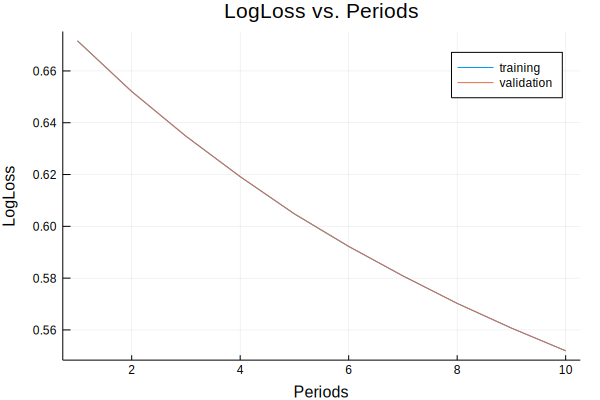

In [15]:
plot(p1)

The following function converts the validation probabilites back to 0-1-predictions.

In [13]:
# Function for converting probabilities to 0/1 decision
function castto01(probabilities)
    out=copy(probabilities)
    for i=1:length(probabilities)
        if(probabilities[i]<0.5)
            out[i]=0
        else
            out[i]=1
        end
    end
    return out
end    

castto01 (generic function with 1 method)

Let's have a look at the accuracy of the model:

In [17]:
evaluation_metrics=DataFrame()
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(test_labels)), vec(validation_probabilities))
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(test_labels), vec(validation_probabilities))
validation_predictions=castto01(validation_probabilities);
evaluation_metrics[:accuracy]=accuracy = sklm.accuracy_score(test_labels, validation_predictions)

p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");

In [18]:
println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

AUC on the validation set: [0.865503]
Accuracy on the validation set: [0.781591]


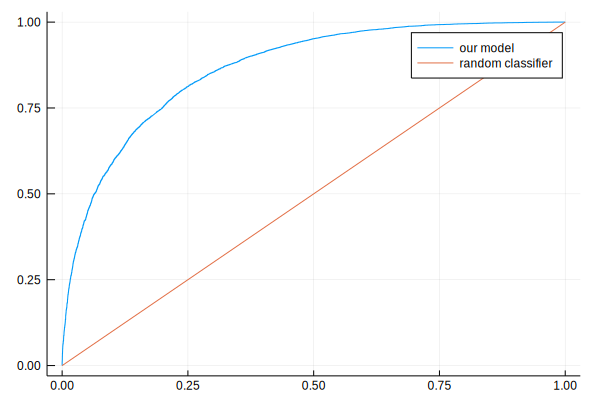

In [19]:
plot(p2)

## Task 2: Use a Deep Neural Network (DNN) Model

The above model is a linear model.  It works quite well.  But can we do better with a DNN model?

Let's constructa NN classification model. Run the following cells, and see how you do.

In [11]:
function train_nn_classification_model(learning_rate,
                     steps, 
                     batch_size, 
                     hidden_units,
                     is_embedding,
                     keep_probability,
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a neural network classification model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A vector describing the layout of the neural network.
    is_embedding: 'true' or 'false' depending on if the first layer of the NN is an embedding layer.
    keep_probability: A `float`, the probability of keeping a node active during one training step.
  Returns:
    p1: Plot of the loss function for the different periods.
    y: The final layer of the TensorFlow network.
    final_probabilities: Final predicted probabilities on the validation examples.
    weight_export: The weights of the first layer of the NN
    feature_columns: TensorFlow feature columns.
    target_columns: TensorFlow target columns.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32, shape=[-1, size(training_examples,2)])
  target_columns = placeholder(Float32, shape=[-1, size(training_targets,2)])
        
  # Network parameters
  push!(hidden_units,size(training_targets,2)) #create an output node that fits to the size of the targets
  activation_functions = Vector{Function}(size(hidden_units,1))
  activation_functions[1:end-1]=z->nn.dropout(nn.relu(z), keep_probability)
  activation_functions[end] = nn.sigmoid #Last function should be idenity as we need the logits  
    
  # create network 
  flag=0
  weight_export=Variable([1])
  Zs = [feature_columns]

  for (ii,(hlsize, actfun)) in enumerate(zip(hidden_units, activation_functions))
        Wii = get_variable("W_$ii"*randstring(4), [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii"*randstring(4), [hlsize], Float32)
        
        if((is_embedding==true) & (flag==0))
            Zii=Zs[end]*Wii 
        else
            Zii = actfun(Zs[end]*Wii + bii)
        end
        push!(Zs, Zii)
        
        if(flag==0)
            weight_export=Wii
            flag=1
        end
  end

  y=Zs[end]
  eps=1e-8
  cross_entropy = -reduce_mean(log(y+eps).*target_columns + log(1-y+eps).*(1-target_columns))
 
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
  
  # Standard Adam Optimizer
  my_optimizer=train.minimize(train.AdamOptimizer(learning_rate), cross_entropy)
 
  run(sess, global_variables_initializer())

    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("LogLoss error (on validation data):")
  training_log_losses = []
  validation_log_losses = []
  for period in 1:periods  
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>construct_feature_columns(features), target_columns=>construct_feature_columns(labels)))
   end
    # Take a break and compute log loss.
    training_log_loss = run(sess, cross_entropy, Dict(feature_columns=> construct_feature_columns(training_examples), target_columns=>construct_feature_columns(training_targets)));    
    validation_log_loss = run(sess, cross_entropy, Dict(feature_columns=> construct_feature_columns(validation_examples), target_columns=>construct_feature_columns(validation_targets)));  
         
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_log_loss)
           
    # Add the loss metrics from this period to our list.
    push!(training_log_losses, training_log_loss)
    push!(validation_log_losses, validation_log_loss)
  end      
        
        
  println("Model training finished.")
  
  # Calculate final predictions (not probabilities, as above).
  final_probabilities = run(sess, y, Dict(feature_columns=> validation_examples, target_columns=>validation_targets))
  final_predictions=0.0.*copy(final_probabilities)
  final_predictions=castto01(final_probabilities)
  
  accuracy = sklm.accuracy_score(validation_targets, final_predictions)
  println("Final accuracy (on validation data): ", accuracy)

  # Output a graph of loss metrics over periods.
  p1=plot(training_log_losses, label="training", title="LogLoss vs. Periods", ylabel="LogLoss", xlabel="Periods")
  p1=plot!(validation_log_losses, label="validation")
  
  return p1, y, final_probabilities, weight_export, feature_columns, target_columns
end

train_nn_classification_model (generic function with 1 method)

In [21]:
sess=Session(Graph())
p1, y, final_probabilities, weight_export, feature_columns, target_columns = train_nn_classification_model(
    0.003, #learning rate
    1000, #steps
    50, #batch_size
    [20, 20], #hidden_units
    false, #is_embedding
    1.0, # keep probability
    train_feature_mat,
    train_labels,
    test_features_mat,
    test_labels)

Training model...
LogLoss error (on validation data):
  period 1: 0.471395788925613
  period 2: 0.45770820644301585
  period 3: 0.44868498081679836
  period 4: 0.4486270877372173
  period 5: 0.44886359529693076
  period 6: 0.45785272663956894
  period 7: 0.4486596600689161
  period 8: 0.44640892834409557
  period 9: 0.44672501642012086
  period 10: 0.44597568632613904
Model training finished.


(Plot{Plots.GRBackend() n=2}, <Tensor Sigmoid:1 shape=(?, 1) dtype=Float32>, Float32[0.759592; 0.194817; … ; 0.910422; 0.592667], TensorFlow.Variables.Variable{Float32}(<Tensor W_1BDge:1 shape=(50, 20) dtype=Float32>, <Tensor W_1BDge/Assign:1 shape=unknown dtype=Float32>), <Tensor placeholder:1 shape=(?, 50) dtype=Float32>, <Tensor placeholder_2:1 shape=(?, 1) dtype=Float32>)

Final accuracy (on validation data): 0.7854314172566903


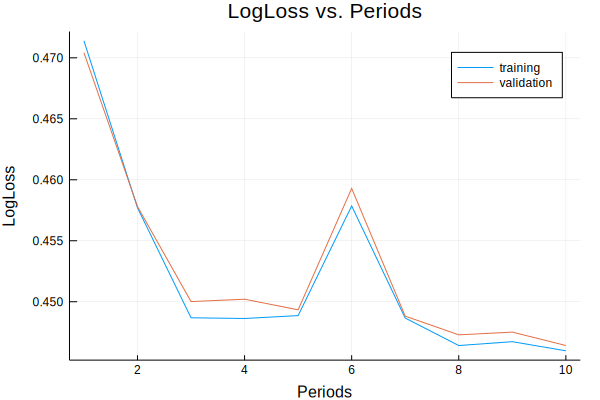

In [22]:
plot(p1)

In [23]:
evaluation_metrics=DataFrame()
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(test_labels)), vec(final_probabilities))
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(test_labels), vec(final_probabilities))
validation_predictions=castto01(final_probabilities);
evaluation_metrics[:accuracy]=accuracy = sklm.accuracy_score(test_labels, validation_predictions)

p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");
println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

AUC on the validation set: [0.871963]
Accuracy on the validation set: [0.785431]


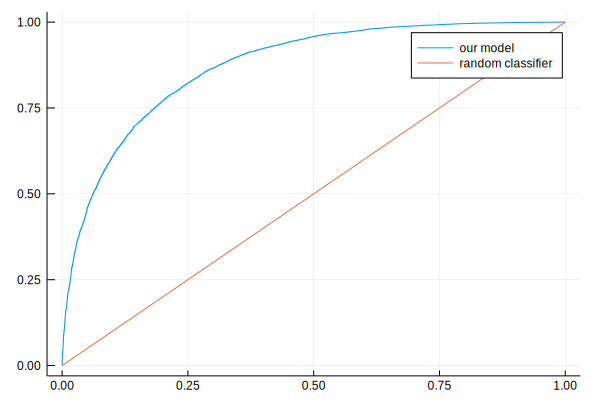

In [24]:
plot(p2)

## Task 3: Use an Embedding with a DNN Model

In this task, we'll implement our DNN model using an embedding column. An embedding column takes sparse data as input and returns a lower-dimensional dense vector as output. We'll add the embedding layer as the first layer in the ``hidden_units``-vector, and set ``is_embedding`` to ``true``.

**NOTE:** *In practice, we might project to dimensions higher than 2, like 50 or 100.  But for now, 2 dimensions is easy to visualize.*

In [14]:
sess=Session(Graph())
p1, y, final_probabilities, weight_export, feature_columns, target_columns = train_nn_classification_model(
    0.003, #learning rate
    1000, #steps
    50, #batch_size
    [2, 20, 20], #hidden_units
    true,
    1.0, # keep probability
    train_feature_mat,
    train_labels,
    test_features_mat,
    test_labels)

Training model...
LogLoss error (on validation data):
  period 1: 0.5663698194950431
  period 2: 0.45220806683037423
  period 3: 0.45205136369869175
  period 4: 0.44547315482684624
  period 5: 0.4489593760718842
  period 6: 0.4484996714455285
  period 7: 0.44584040864739305
  period 8: 0.4457339047966633
  period 9: 0.4464958611862487
  period 10: 0.4485086547636147
Model training finished.


(Plot{Plots.GRBackend() n=2}, <Tensor Sigmoid:1 shape=(?, 1) dtype=Float32>, Float32[0.736896; 0.157856; … ; 0.895887; 0.54718], TensorFlow.Variables.Variable{Float32}(<Tensor W_1fwgD:1 shape=(50, 2) dtype=Float32>, <Tensor W_1fwgD/Assign:1 shape=unknown dtype=Float32>), <Tensor placeholder:1 shape=(?, 50) dtype=Float32>, <Tensor placeholder_2:1 shape=(?, 1) dtype=Float32>)

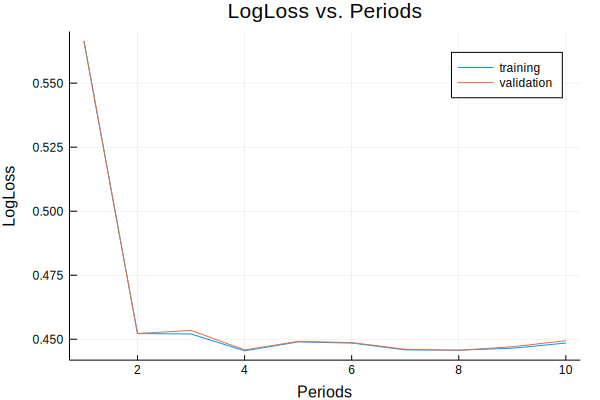

Final accuracy (on validation data): 0.7846313852554102


In [15]:
plot(p1)

In [16]:
evaluation_metrics=DataFrame()
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(test_labels)), vec(final_probabilities))
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(test_labels), vec(final_probabilities))
validation_predictions=castto01(final_probabilities);
evaluation_metrics[:accuracy]=accuracy = sklm.accuracy_score(test_labels, validation_predictions)

p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");
println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

AUC on the validation set: [0.873001]
Accuracy on the validation set: [0.784631]


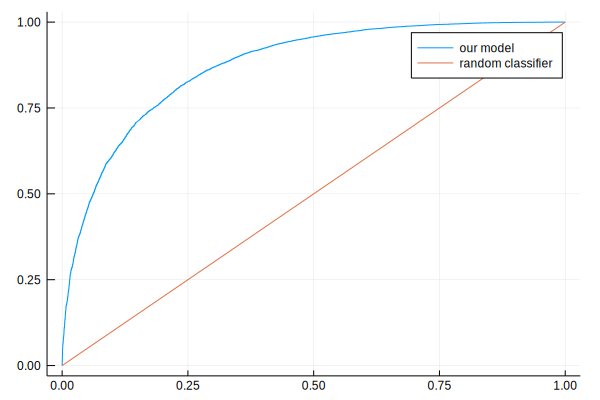

In [17]:
plot(p2)

## Task 4: Examine the Embedding

Let's now take a look at the actual embedding space, and see where the terms end up in it. Do the following:
1. Run the following code to see the embedding we trained in **Task 3**. Do things end up where you'd expect?

2. Re-train the model by rerunning the code in **Task 3**, and then run the embedding visualization below again. What stays the same? What changes?

3. Finally, re-train the model again using only 10 steps (which will yield a terrible model). Run the embedding visualization below again. What do you see now, and why?

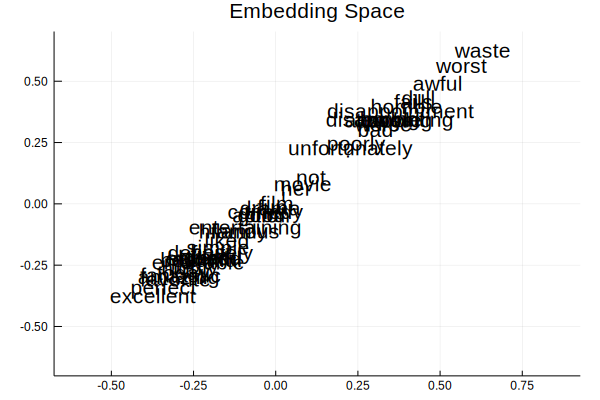

In [18]:
xy_coord=run(sess, weight_export, Dict(feature_columns=> test_features_mat, target_columns=>test_labels))
p3=plot(title="Embedding Space", xlims=(minimum(xy_coord[:,1])-0.3, maximum(xy_coord[:,1])+0.3),  ylims=(minimum(xy_coord[:,2])-0.1, maximum(xy_coord[:,2]) +0.3)  )
for term_index=1:length(informative_terms)
    p3=annotate!(xy_coord[term_index,1], xy_coord[term_index,1], informative_terms[term_index] )
end
plot(p3)

## Task 5:  Try to improve the model's performance

See if you can refine the model to improve performance. A couple things you may want to try:

* **Changing hyperparameters**, or **using a different optimizer** than Adam (you may only gain one or two accuracy percentage points following these strategies).
* **Adding additional terms to `informative_terms`.** There's a full vocabulary file with all 30,716 terms for this data set that you can use at: https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt You can pick out additional terms from this vocabulary file, or use the whole thing.

In the following code, we will import the whole vocabulary file and run the model with it. 

In [30]:
vocabulary=Array{String}(0)
open("terms.txt") do file
    for ln in eachline(file)
        push!(vocabulary, ln)
    end
end

In [31]:
vocabulary

30716-element Array{String,1}:
 "the"      
 "."        
 ","        
 "and"      
 "a"        
 "of"       
 "to"       
 "is"       
 "in"       
 "i"        
 "it"       
 "this"     
 "'"        
 ⋮          
 "soapbox"  
 "softening"
 "user's"   
 "od"       
 "potter's" 
 "renard"   
 "impacting"
 "pong"     
 "nobly"    
 "nicol"    
 "ff"       
 "MISSING"  

We will now load the test and training features matrices from disk. Open and run the **Conversion of Movie-review data to one-hot encoding**-notebook to prepare the ``IMDB_fullmatrix_datacolumns.jld``-file. The notebook can be found [here](https://github.com/sdobber/MLCrashCourse/blob/master/Conversion%20of%20Movie-review%20data%20to%20one-hot%20encoding.ipynb).

In [48]:
using JLD
train_features_full=load("IMDB_fullmatrix_datacolumns.jld", "train_features_full")
test_features_full=load("IMDB_fullmatrix_datacolumns.jld", "test_features_full")

24999×30716 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  1.0

Now run the session with the full vocabulary file. Again, this will take a long time to finish. It assigns about 50GB of memory.

In [49]:
sess=Session(Graph())
p1, y, final_probabilities, weight_export, feature_columns, target_columns = train_nn_classification_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.003, #learning rate
    1000, #steps
    50, #batch_size
    [2, 20, 20], #hidden_units
    true,
    1.0, # keep probability
    train_features_full,
    train_labels,
    test_features_full,
    test_labels)

Training model...
LogLoss error (on validation data):
  period 1: 0.37313920231826037
  period 2: 0.26477444394028044
  period 3: 0.25086412221834486
  period 4: 0.2087771610933073
  period 5: 0.19335710666766756
  period 6: 0.16094674715105722
  period 7: 0.15969771663371266
  period 8: 0.14275753878385306
  period 9: 0.13488925137953908
  period 10: 0.11471432399972212
Model training finished.


(Plot{Plots.GRBackend() n=2}, <Tensor Sigmoid:1 shape=(?, 1) dtype=Float32>, Float32[0.0975639; 0.0719205; … ; 0.993713; 0.678265], TensorFlow.Variables.Variable{Float32}(<Tensor W_1tR5j:1 shape=(30716, 2) dtype=Float32>, <Tensor W_1tR5j/Assign:1 shape=unknown dtype=Float32>), <Tensor placeholder:1 shape=(?, 30716) dtype=Float32>, <Tensor placeholder_2:1 shape=(?, 1) dtype=Float32>)

Final accuracy (on validation data): 0.8656746269850794


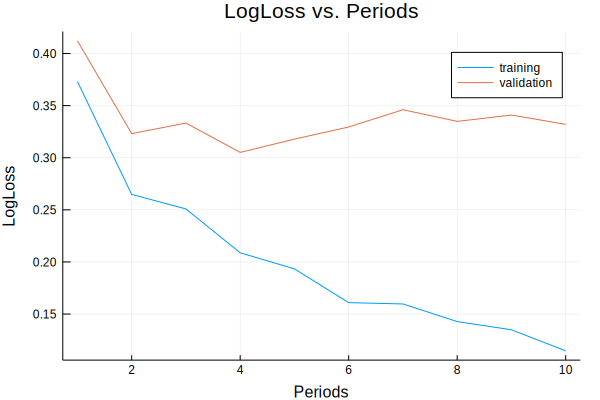

In [50]:
plot(p1)

In [51]:
evaluation_metrics=DataFrame()
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(test_labels)), vec(final_probabilities))
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(test_labels), vec(final_probabilities))
validation_predictions=castto01(final_probabilities);
evaluation_metrics[:accuracy]=accuracy = sklm.accuracy_score(test_labels, validation_predictions)

p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");
println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

AUC on the validation set: [0.939391]
Accuracy on the validation set: [0.865675]


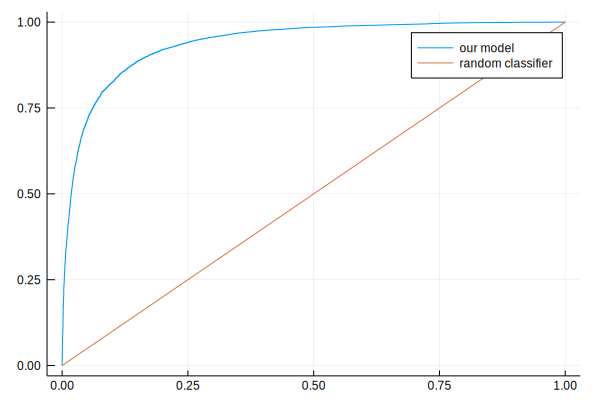

In [52]:
plot(p2)

# Task 6: Try out sparse matrices

We will now convert the feature matrices from the previous step to sparse matrices and re-run our code. The sparse matrices take about 350MB of memory. The code for the NN will still convert the sparse matrix containing the data for the current batch to a full matrix, which leads to a memory requirement of about 35GB.

In [54]:
train_features_sparse=sparse(train_features_full)
test_features_sparse=sparse(test_features_full)

24999×30716 SparseMatrixCSC{Float64,Int64} with 10780292 stored entries:
  [1    ,     1]  =  1.0
  [2    ,     1]  =  1.0
  [3    ,     1]  =  1.0
  [4    ,     1]  =  1.0
  [5    ,     1]  =  1.0
  [6    ,     1]  =  1.0
  [7    ,     1]  =  1.0
  [8    ,     1]  =  1.0
  [9    ,     1]  =  1.0
  [10   ,     1]  =  1.0
  ⋮
  [24977, 30715]  =  1.0
  [24978, 30715]  =  1.0
  [24979, 30715]  =  1.0
  [24981, 30715]  =  1.0
  [24982, 30715]  =  1.0
  [24983, 30715]  =  1.0
  [24984, 30715]  =  1.0
  [24989, 30715]  =  1.0
  [24990, 30715]  =  1.0
  [24993, 30715]  =  1.0
  [24996, 30715]  =  1.0

In [56]:
# For saving the data
#save("IMDB_sparsematrix_datacolumns.jld", "train_features_sparse", train_features_sparse, "test_features_sparse", test_features_sparse)

In [55]:
sess=Session(Graph())
p1, y, final_probabilities, weight_export, feature_columns, target_columns = train_nn_classification_model(
    0.003, #learning rate
    1000, #steps
    50, #batch_size
    [2, 20, 20], #hidden_units
    true,
    1.0, # keep probability
    train_features_sparse,
    train_labels,
    test_features_sparse,
    test_labels)

Training model...
LogLoss error (on validation data):
  period 1: 0.4264791202329761
  period 2: 0.27906764597962996
  period 3: 0.24588130824603802
  period 4: 0.24137786867062228
  period 5: 0.1982403807820223
  period 6: 0.195120145753206
  period 7: 0.15590201135616108
  period 8: 0.145190807054994
  period 9: 0.128827185543495
  period 10: 0.12583784552275887
Model training finished.


(Plot{Plots.GRBackend() n=2}, <Tensor Sigmoid:1 shape=(?, 1) dtype=Float32>, Float32[0.302512; 0.50181; … ; 0.977541; 0.652478], TensorFlow.Variables.Variable{Float32}(<Tensor W_1gvhS:1 shape=(30716, 2) dtype=Float32>, <Tensor W_1gvhS/Assign:1 shape=unknown dtype=Float32>), <Tensor placeholder:1 shape=(?, 30716) dtype=Float32>, <Tensor placeholder_2:1 shape=(?, 1) dtype=Float32>)

Final accuracy (on validation data): 0.8696347853914157


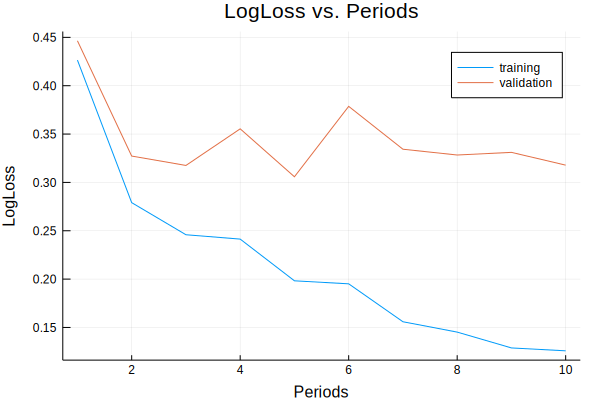

In [56]:
plot(p1)

In [57]:
evaluation_metrics=DataFrame()
false_positive_rate, true_positive_rate, thresholds = sklm.roc_curve(
    vec(construct_feature_columns(test_labels)), vec(final_probabilities))
evaluation_metrics[:auc]=sklm.roc_auc_score(construct_feature_columns(test_labels), vec(final_probabilities))
validation_predictions=castto01(final_probabilities);
evaluation_metrics[:accuracy]=accuracy = sklm.accuracy_score(test_labels, validation_predictions)

p2=plot(false_positive_rate, true_positive_rate, label="our model")
p2=plot!([0, 1], [0, 1], label="random classifier");
println("AUC on the validation set: ",  evaluation_metrics[:auc])
println("Accuracy on the validation set: ", evaluation_metrics[:accuracy])

AUC on the validation set: [0.940761]
Accuracy on the validation set: [0.869635]


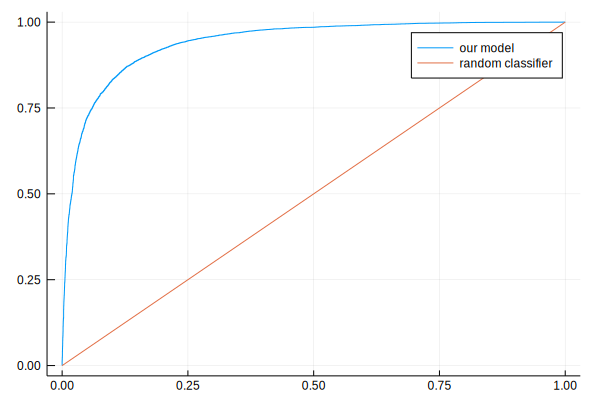

In [58]:
plot(p2)

## A Final Word

We may have gotten a DNN solution with an embedding that was better than our original linear model, but the linear model was also pretty good and was quite a bit faster to train. Linear models train more quickly because they do not have nearly as many parameters to update or layers to backprop through.

In some applications, the speed of linear models may be a game changer, or linear models may be perfectly sufficient from a quality standpoint. In other areas, the additional model complexity and capacity provided by DNNs might be more important. When defining your model architecture, remember to explore your problem sufficiently so that you know which space you're in.